- import lib

In [2]:
# What version of Python do you have?
import sys

from collections import Counter

import tensorflow.keras
import pandas as pd
import sklearn as sk
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
import tensorflow as tf
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import demoji
import datetime

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 1.13.1
Keras Version: 2.2.4-tf

Python 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas 1.0.1
Scikit-Learn 0.22.1
GPU is NOT AVAILABLE


- read data

In [2]:
tweet_vector_df = pd.read_csv("./data_vectors/vectors-100-2019-02-06.csv")

- SVD

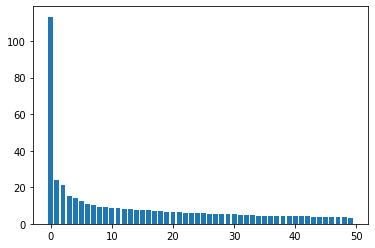

In [3]:
u, s, vh = np.linalg.svd(tweet_vector_df, full_matrices=True)
num_of_bars = 50
_ = plt.bar(np.arange(num_of_bars), s[:num_of_bars])

In [4]:
threshold = 15

basis_events = []
for i in range(len(s)):
    if s[i] < threshold: break
    if s[i] >= threshold: basis_events.append(vh[i])

In [5]:
len(basis_events)

4

- project each non-basis vectors onto the basis vectors and aggregate them

In [6]:
aggregated_vector = [0 for i in range(768)]
for idx, tweet in tweet_vector_df.iterrows():
    # iterate through each basis event
    for basis_event in basis_events:
        norm = np.linalg.norm(basis_event)
        aggregated_vector = np.add(aggregated_vector, np.multiply(np.dot(tweet.to_list(), basis_event) / norm, basis_event))
#         print(np.dot(tweet.to_list(), basis_event))
#         print("==============")
# print(aggregated_vector)

- assign sentiment class

In [3]:
def sentiment_class(num):
    if num >= 1/3: 
        return 1
    elif num >=-1/3: 
        return 0
    else: 
        return -1
def sentiment_class2(num):
    if num >= 1/15 or num < -1/15: 
        return 11
    else: 
        return 22

- function to aggregate vector with projection

In [4]:
def aggregator(date):
    # read date
    tweet_vector_df = pd.read_csv("./data_vectors/vectors-10000-" + date +".csv")
    tweet_vector_df['sentiment_class'] = tweet_vector_df.sentiment.apply(sentiment_class)
    
    # SMOTE oversampling
    all_rows = tweet_vector_df.values.tolist()
    X = [row[: -1] for row in all_rows]
    y = [row[-1] for row in all_rows]
    sentiment_count = Counter(y)
    if sentiment_count[0] > sentiment_count[1] + sentiment_count[-1]:
        if min(sentiment_count.values()) > 3:
            sm = SMOTE(random_state=2, k_neighbors=3)
            X_res, y_res = sm.fit_resample(X, y)

            # re-assemble back to dataframe
            tweet_vector_df = pd.DataFrame(X_res)
            tweet_vector_df = tweet_vector_df.rename(columns={768: "sentiment_score"})
            tweet_vector_df['sentiment_class'] = y_res
    
    # print(tweet_vector_df.shape, tweet_vector_df.columns)
    # svd
    u, s, vh = np.linalg.svd(tweet_vector_df, full_matrices=True)
    
    # generate basis events
    threshold = 15

    basis_events = []
    for i in range(len(s)):
        if s[i] < threshold: break
        if s[i] >= threshold: basis_events.append(vh[i])
    
    # projection
    aggregated_vector = [0 for i in range(797)]
    for idx, tweet in tweet_vector_df.iterrows():
        # iterate through each basis event
        for basis_event in basis_events:
            norm = np.linalg.norm(basis_event)
            aggregated_vector = np.add(aggregated_vector, np.multiply(np.dot(tweet.to_list(), basis_event) / norm, basis_event))
    return np.concatenate((np.array([date]), aggregated_vector))

In [17]:
# plain addition version of aggregator
def aggregator(date):
    # read date
    tweet_vector_df = pd.read_csv("./data_vectors/vectors-10000-" + date +".csv")
    tweet_vector_df['sentiment_class'] = tweet_vector_df.sentiment.apply(sentiment_class)
    
    # trigger SMOTE oversampling iff neutral ratio too large
    all_rows = tweet_vector_df.values.tolist()
    X = [row[: -1] for row in all_rows]
    y = [row[-1] for row in all_rows]
    sentiment_count = Counter(y)
    if sentiment_count[0] > sentiment_count[1] + sentiment_count[-1]:
        if min(sentiment_count.values()) > 3:
            sm = SMOTE(random_state=2, k_neighbors=3)
            X_res, y_res = sm.fit_resample(X, y)

            # re-assemble back to dataframe
            tweet_vector_df = pd.DataFrame(X_res)
            tweet_vector_df = tweet_vector_df.rename(columns={768: "sentiment_score"})
            tweet_vector_df['sentiment_class'] = y_res
    
    '''if sentiment_count[1] <= 3 or sentiment_count[-1] <= 3:
        # read date
        tweet_vector_df['sentiment_class'] = tweet_vector_df.sentiment.apply(sentiment_class2)

        # SMOTE oversampling
        all_rows = tweet_vector_df.values.tolist()
        X = [row[: -1] for row in all_rows]
        y = [row[-1] for row in all_rows]
    sm = SMOTE(random_state=2, k_neighbors=3)
    X_res, y_res = sm.fit_resample(X, y)
    
    # re-assemble back to dataframe
    tweet_vector_df = pd.DataFrame(X_res)
    tweet_vector_df = tweet_vector_df.rename(columns={768: "sentiment_score"})
    tweet_vector_df['sentiment_class'] = y_res'''
    
    # print(tweet_vector_df.shape, tweet_vector_df.columns)
    # svd
    u, s, vh = np.linalg.svd(tweet_vector_df, full_matrices=True)
    
    # generate basis events
    threshold = 15

    basis_events = []
    for i in range(len(s)):
        if s[i] < threshold: break
        if s[i] >= threshold: basis_events.append(vh[i])
    
    # projection
    aggregated_vector = [0 for i in range(tweet_vector_df.shape[1])]
    for idx, tweet in tweet_vector_df.iterrows():
        aggregated_vector = np.add(aggregated_vector, tweet.to_list())
    return np.concatenate((np.array([date]), aggregated_vector))

- wrap up

In [18]:
# Inclusive on both sides
start_date = datetime.date(2019, 2, 6)
end_date = datetime.date(2020, 2, 6)
time_window = (end_date - start_date).days + 1

sample_df = pd.read_csv("./data_vectors/vectors-10000-2019-02-06.csv")

feature_by_date = pd.DataFrame(columns=['date'] + list(sample_df.columns) + ['sentiment_class'])

for single_date in (start_date + datetime.timedelta(n) for n in range(time_window)): 
    this_date = single_date.strftime("%Y-%m-%d")
    new_row_df = pd.DataFrame(aggregator(this_date)).transpose()
    new_row_df = new_row_df.rename(columns={0: "Date"})
    new_row_df.columns = ['date'] + list(sample_df.columns) + ['sentiment_class']
    feature_by_date = pd.concat([feature_by_date, new_row_df], ignore_index=True)
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("finished %s" % this_date)
    sys.stdout.flush()
print("\nall finished")

finished 2020-02-06
all finished


In [19]:
feature_by_date = feature_by_date.rename(columns={"date": "Date"})
feature_by_date.drop(['sentiment_class'], axis=1).to_csv("aggregated_vector.csv", index=False)

In [20]:
feature_by_date

,Date,0,1,2,3,4,5,6,7,8,...,num_pos_NN,num_neg_JJ,num_neg_RB,num_neg_VB,num_neg_NN,total_score_JJ,total_score_RB,total_score_VB,total_score_NN,sentiment_class
0,2019-02-06,-31.06537429915035,26.964166993464612,207.58720202010565,-29.100772182048704,95.53124272803879,-118.98581534490141,-24.375885899932513,138.74164949586037,-99.35952948246472,...,55.419917131976916,53.802889586373816,42.12778481249996,0.0,59.77948079232747,23.410036492091198,4.487774748641578,1.99906064426531,9.431499582390815,0.0
1,2019-02-07,-1.9547378430000009,-14.441649583200002,63.646112390999974,-10.731835941300002,39.55415032889999,-40.863589785699986,-10.272326656500006,47.88067524670001,-21.6208396538,...,18.0,37.0,8.0,2.0,12.0,5.026641414141414,2.214285714285715,0.675,6.566666666666666,12.0
2,2019-02-08,5.805648479300003,-10.267494661,53.63059216899999,0.30616061276000045,39.19753926020002,-29.6630420611,-12.035485623449995,48.97629274940002,-21.195179270000004,...,24.0,16.0,1.0,1.0,12.0,8.259350649350651,2.3499999999999996,0.9000000000000002,9.3,18.0
3,2019-02-09,9.036617841070512,-14.880874201398832,62.90174624018739,-7.784256250025722,55.92839910457414,-37.013677917527474,-21.02612971864809,20.73235161580805,-25.876026990824723,...,23.495188476191792,22.790351325427157,0.0,0.0,12.0,13.738121505119203,0.7303781357752022,6.300583614271685,10.147594238095898,59.0
4,2019-02-10,10.978263321000005,-4.288860086999997,40.388908541,-4.523574988499999,27.666125486000013,-24.329436933999986,-10.047940654800001,26.261659782299997,-17.949837299299997,...,22.0,22.0,1.0,0.0,12.0,4.558333333333334,2.3642857142857143,0.5,9.400000000000002,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-02-02,25.254254662674438,-11.827054759622884,51.62565097607681,-3.246908004790751,43.76892697424784,-31.360492717538747,-7.545925943411508,38.36754771271259,-24.80026548419918,...,31.705104713392124,14.0,0.0,1.0,15.648511120026665,13.303002089469565,1.5142857142857142,0.0,14.070126800694732,50.0
362,2020-02-03,76.94523069654382,-183.5716723032944,558.6775934596141,-4.645623426619663,195.66549944157148,-269.8816737445945,-104.52817828611548,501.6433080147235,-351.42633289929626,...,81.48325414736135,277.04568458892487,32.600911296283975,1.0,24.0,66.13137594795285,10.669190480587494,4.101283038031051,35.81395934085977,0.0
363,2020-02-04,10.652329529262062,-92.97790162115263,290.5389107669862,22.162449371609387,87.50611519088693,-172.8079820152349,-44.02213733564593,256.12853038018665,-145.85243192728552,...,49.21347896373063,133.93706127254978,55.4279761277329,2.0,96.76062759268734,14.331231381876187,-12.310917724499218,2.495261620329243,-45.60254041626289,0.0
364,2020-02-05,1.1656143777,-8.909696155700004,51.497865974,-9.279747284,24.929762255130015,-28.78734867610001,-2.598412654549999,32.407284685600004,-24.101177456099997,...,14.0,18.0,10.0,1.0,5.0,11.373149350649348,-0.5944444444444446,0.3,5.927380952380952,10.0
